In [95]:
%pip install matplotlib pandas duckdb


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


<br><br><br>

# [LA] Issued Building Permits: Read and Merge

All 3 of these datasets need to be combined:

* [LADBS - Building Permits Issued from 2020 to Present (N)](https://data.lacity.org/City-Infrastructure-Service-Requests/Building-and-Safety-Building-Permits-Issued-from-2/pi9x-tg5x/about_data "Building and Safety - Building Permits Issued from 2020 to Present (N) | Los Angeles - Open Data Portal")
* [LADBS - Building Permits Issued Between 2010 and 2019 (N)](https://data.lacity.org/City-Infrastructure-Service-Requests/Building-and-Safety-Building-Permits-Issued-Betwee/dyxf-7hc4/about_data "Building and Safety - Building Permits Issued Between 2010 and 2019 (N) | Los Angeles - Open Data Portal")
* [LADBS - Building Permits Issued Before 2010 (N)](https://data.lacity.org/City-Infrastructure-Service-Requests/Building-and-Safety-Building-Permits-Issued-Before/e67z-kt2n/about_data "Building and Safety - Building Permits Issued Before 2010 (N) | Los Angeles - Open Data Portal")

Fortunately, they share the same columns, so merging is straightforward using `pd.concat()`.


In [88]:
import pandas as pd
import duckdb

file_paths = [
    'input/los_angeles/Building_and_Safety_-_Building_Permits_Issued_Before_2010__N__20250810.csv',
    'input/los_angeles/Building_and_Safety_-_Building_Permits_Issued_Between_2010_and_2019__N__20250810.csv',
    'input/los_angeles/Building_and_Safety_-_Building_Permits_Issued_from_2020_to_Present__N__20250810.csv',
]
date_fields = ['SUBMITTED_DATE', 'ISSUE_DATE', 'COFO_DATE', 'STATUS_DATE']
permits_lacity = pd.concat(
    (pd.read_csv(f, parse_dates=date_fields) for f in file_paths),
    ignore_index=True,
)
permits_lacity['issue_year'] = permits_lacity['ISSUE_DATE'].dt.year
print(permits_lacity.dtypes)

/tmp/ipykernel_15607/3421569200.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  (pd.read_csv(f, parse_dates=date_fields) for f in file_paths),
/tmp/ipykernel_15607/3421569200.py:11: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  (pd.read_csv(f, parse_dates=date_fields) for f in file_paths),


PERMIT_NBR                 object
PRIMARY_ADDRESS            object
ZIP_CODE                  float64
CD                        float64
PIN_NBR                    object
APN                        object
ZONE                       object
APC                        object
CPA                        object
CNC                        object
HL                         object
CT                         object
PERMIT_GROUP               object
PERMIT_TYPE                object
PERMIT_SUB_TYPE            object
USE_CODE                  float64
USE_DESC                   object
SUBMITTED_DATE     datetime64[ns]
ISSUE_DATE         datetime64[ns]
COFO_DATE          datetime64[ns]
DU_CHANGED                float64
ADU_CHANGED               float64
JUNIOR_ADU                float64
SQUARE_FOOTAGE            float64
STATUS_DESC                object
STATUS_DATE                object
VALUATION                 float64
CONSTRUCTION               object
HEIGHT                    float64
TYPE_LAT_LON  

# [LA] Annotate permits with ADU hints:

* `certainly_adu` - explicitly marked as an ADU via `use_desc` code.
* `probably_adu` - only marked using a residential-type code, but the long description clearly indicates that it is for an ADU.

In [93]:
sql_string = """
SELECT *,

       use_desc in (
         'Accessory Dwelling Unit',
         'Junior Accessory Dwelling Unit'
       ) and not (
            work_desc ilike '%supplemental%'
         or work_desc ilike '%suppl.%'
         or work_desc ilike '%suppl to%'
       ) as certainly_adu,
    
       use_desc in (
         'Apartment',
         'Duplex',
         'Dwelling - Single Family',
         'Garage - Private'
       ) and (
            work_desc ilike '%(n) adu%'
         or work_desc ilike '%new adu%'
         or work_desc ilike '%one adu%'
         or work_desc ilike '%(n) (% sf) adu%'
         or work_desc ilike '%new (% sf) adu%'
         or work_desc ilike '%one (% sf) adu%'
         or work_desc ilike '%(n) accessory dwelling unit%'
         or work_desc ilike '%new accessory dwelling unit%'
         or work_desc ilike '%one accessory dwelling unit%'
         or work_desc ilike '%(n) (% sf) accessory dwelling unit%'
         or work_desc ilike '%new (% sf) accessory dwelling unit%'
         or work_desc ilike '%one (% sf) accessory dwelling unit%'
       ) and not (
            work_desc ilike '%supplemental%'
         or work_desc ilike '%suppl.%'
         or work_desc ilike '%suppl to%'
       ) as probably_adu
    
FROM permits_lacity
"""

permits_lacity = duckdb.query(sql_string).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

# [LA] Try to identify trends between certainly/probably ADUs.

<Axes: xlabel='issue_year'>

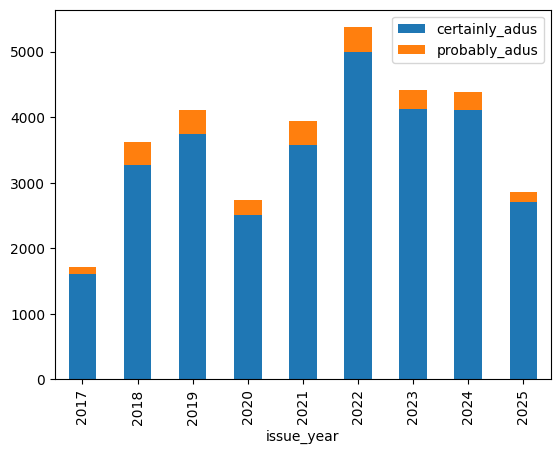

In [108]:
sql_string = """
  SELECT issue_year,
         sum(certainly_adu) as certainly_adus,
         sum(probably_adu) as probably_adus,
         sum(certainly_adu) + sum(probably_adu) as all_adus
    FROM permits_lacity
   WHERE (certainly_adu or probably_adu)
     AND issue_year >= 2017
group by issue_year
order by issue_year
"""

adu_permits_issued_by_year = duckdb.query(sql_string).df()
adu_permits_issued_by_year.plot(x='issue_year', y=['certainly_adus', 'probably_adus'], kind='bar', stacked=True)

<Axes: xlabel='issue_year'>

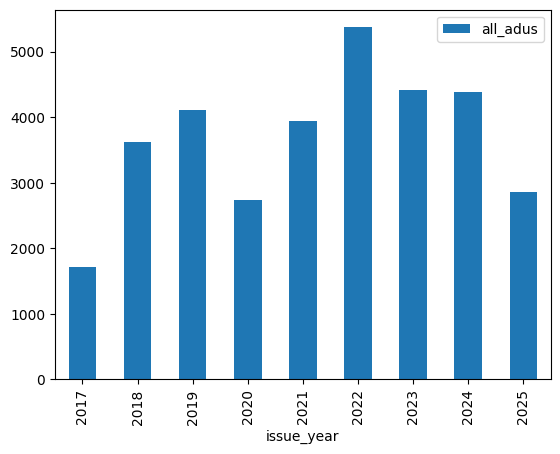

In [109]:
adu_permits_issued_by_year.plot(x='issue_year', y=['all_adus'], kind='bar')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   issue_year  lacity_adu_permits_issued  saccity_adu_permits_issued  \
0        2017                       1715                          18   
1        2018                       3622                          30   
2        2019                       4105                          57   
3        2020                       2740                          76   
4        2021                       3944                         170   
5        2022                       5372                         259   
6        2023                       4410                         291   
7        2024                       4379                         338   

   lacity_adu_permits_issued_per1k  saccity_adu_permits_issued_per1k  
0                         0.442158                          0.034199  
1                         0.933817                          0.056999  
2                         1.058343                          0.108298  
3                         0.706422                          0.14439

<Axes: xlabel='issue_year'>

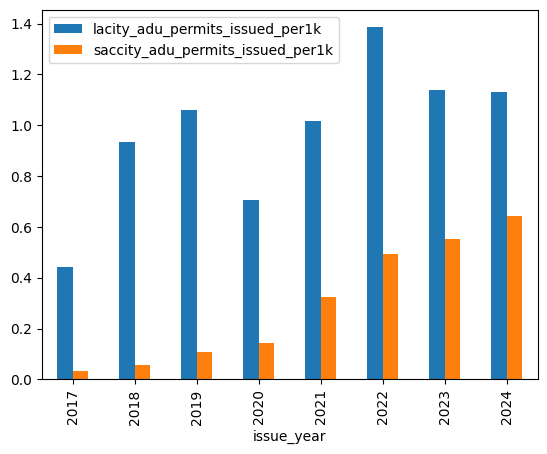

In [91]:
sql_string = """
WITH annotated AS (
  SELECT *,
  
    use_desc in (
      'Accessory Dwelling Unit',
      'Junior Accessory Dwelling Unit'
    )
    and not (
         work_desc ilike '%supplemental%'
      or work_desc ilike '%suppl.%'
      or work_desc ilike '%suppl to%'
    ) as certainly_adu,
    
    use_desc in (
      'Apartment',
      'Duplex',
      'Dwelling - Single Family',
      'Garage - Private'
    )
    and (
         work_desc ilike '%(n) adu%'
      or work_desc ilike '%new adu%'
      or work_desc ilike '%one adu%'
      or work_desc ilike '%(n) (% sf) adu%'
      or work_desc ilike '%new (% sf) adu%'
      or work_desc ilike '%one (% sf) adu%'
      or work_desc ilike '%(n) accessory dwelling unit%'
      or work_desc ilike '%new accessory dwelling unit%'
      or work_desc ilike '%one accessory dwelling unit%'
      or work_desc ilike '%(n) (% sf) accessory dwelling unit%'
      or work_desc ilike '%new (% sf) accessory dwelling unit%'
      or work_desc ilike '%one (% sf) accessory dwelling unit%'
    )
    and not (
         work_desc ilike '%supplemental%'
      or work_desc ilike '%suppl.%'
      or work_desc ilike '%suppl to%'
    ) as probably_adu,
    
  FROM permits_lacity
)

SELECT issue_year, count(*) as lacity_adu_permits_issued
FROM annotated
WHERE certainly_adu or probably_adu
group by issue_year
having lacity_adu_permits_issued > 1
order by issue_year
"""

adu_permits_issued_by_year = duckdb.query(sql_string).df()

saccity_adu_permits_issued = pd.DataFrame(
    data={
      'issue_year': [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
      'saccity_adu_permits_issued': [18, 30, 57, 76, 170, 259, 291, 338],
    },
)
adu_permits_issued_by_year = adu_permits_issued_by_year.merge(saccity_adu_permits_issued)

lacity_population = 3878704
saccity_population = 526327

adu_permits_issued_by_year['lacity_adu_permits_issued_per1k'] = (
    adu_permits_issued_by_year['lacity_adu_permits_issued'] / lacity_population * 1000
)
adu_permits_issued_by_year['saccity_adu_permits_issued_per1k'] = (
    adu_permits_issued_by_year['saccity_adu_permits_issued'] / saccity_population * 1000
)

print(adu_permits_issued_by_year)
adu_permits_issued_by_year.plot(x='issue_year', y=['lacity_adu_permits_issued_per1k', 'saccity_adu_permits_issued_per1k'], kind='bar')

<br><br><br>

# Los Angeles Issued ADU Permits: Sample Descriptions

Permit descriptios could contain the clues needed to identify Los Angeles ADU permits using pre-approved plans (vs. non-pre-approved).

Unfortunately, I can't find any pattern in the noise. Sacramento building department staff do better job at including certain key words like "shelf-ready ADU" in their descriptions.

In [80]:
sql_string = """
WITH annotated AS (
  SELECT *,
  
    use_desc in (
      'Accessory Dwelling Unit',
      'Junior Accessory Dwelling Unit'
    )
    and not (
         work_desc ilike '%supplemental%'
      or work_desc ilike '%suppl.%'
      or work_desc ilike '%suppl to%'
    ) as certainly_adu,
    
    use_desc in (
      'Apartment',
      'Duplex',
      'Dwelling - Single Family',
      'Garage - Private'
    )
    and (
         work_desc ilike '%(n) adu%'
      or work_desc ilike '%new adu%'
      or work_desc ilike '%one adu%'
      or work_desc ilike '%(n) (% sf) adu%'
      or work_desc ilike '%new (% sf) adu%'
      or work_desc ilike '%one (% sf) adu%'
      or work_desc ilike '%(n) accessory dwelling unit%'
      or work_desc ilike '%new accessory dwelling unit%'
      or work_desc ilike '%one accessory dwelling unit%'
      or work_desc ilike '%(n) (% sf) accessory dwelling unit%'
      or work_desc ilike '%new (% sf) accessory dwelling unit%'
      or work_desc ilike '%one (% sf) accessory dwelling unit%'
    )
    and not (
         work_desc ilike '%supplemental%'
      or work_desc ilike '%suppl.%'
      or work_desc ilike '%suppl to%'
    ) as probably_adu,
    
  FROM permits_lacity
)

SELECT year("ISSUE_DATE") as issue_year, use_desc, work_desc, *
FROM annotated
WHERE (certainly_adu or probably_adu)
  and issue_year = 2024
"""

adu_permits_issued_digging = duckdb.query(sql_string).df()
with pd.option_context('display.max_rows', 100, 'display.max_columns', None, 'display.max_colwidth', 200):
    display(adu_permits_issued_digging.sample(n=100))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,issue_year,USE_DESC,WORK_DESC,PERMIT_NBR,PRIMARY_ADDRESS,ZIP_CODE,CD,PIN_NBR,APN,ZONE,APC,CPA,CNC,HL,CT,PERMIT_GROUP,PERMIT_TYPE,PERMIT_SUB_TYPE,USE_CODE,USE_DESC_1,SUBMITTED_DATE,ISSUE_DATE,COFO_DATE,DU_CHANGED,ADU_CHANGED,JUNIOR_ADU,SQUARE_FOOTAGE,STATUS_DESC,STATUS_DATE,VALUATION,CONSTRUCTION,HEIGHT,TYPE_LAT_LON,LAT,LON,WORK_DESC_1,EV,Solar,business_unit,REFRESH_TIME,GEOLOCATION,Business Unit,certainly_adu,probably_adu
4275,2024,Accessory Dwelling Unit,"*EPLAN* NEW 2-STORY DETACHED ADU PER GCS 65852.2(e)(1)(B) AND LAMC 12.22 A.33(c),(d) AND (g)SOLAR INSTALLATION REQ'D TO MEET 2.2 KW PER TITLE 24 PRIOR TO COFO",23010-10000-02996,6645 W COLGATE AVE,90048.0,5.0,138B173 1194,5511043010,R1-1-RFA,Central,Wilshire,Mid City West,None,2148.00,Building,Bldg-New,1 or 2 Family Dwelling,1.0,Accessory Dwelling Unit,2023-08-01,2024-01-11,NaT,NaN,1.0,NaN,771.00,Issued,2024-01-11 00:00:00,150000.00,Type V-B Construction,18.00,PIN,34.070506,-118.372039,"*EPLAN* NEW 2-STORY DETACHED ADU PER GCS 65852.2(e)(1)(B) AND LAMC 12.22 A.33(c),(d) AND (g)SOLAR INSTALLATION REQ'D TO MEET 2.2 KW PER TITLE 24 PRIOR TO COFO",N,N,None,08/04/2025,POINT (-118.3720385 34.07050606),Regular Plan Check,True,False
1084,2024,Accessory Dwelling Unit,EPLAN New Detached ADU per LAMC 12.22 A.33(c)-(d).,24010-10000-02004,3151 1/2 W LACLEDE AVE,90039.0,13.0,153B209 846,5436009032,[Q]RD2-1-RIO,East Los Angeles,Northeast Los Angeles,Atwater Village,None,1871.02,Building,Bldg-New,1 or 2 Family Dwelling,1.0,Accessory Dwelling Unit,2024-05-15,2024-09-27,2025-02-05,NaN,1.0,NaN,324.00,CofO Issued,2025-02-05 00:00:00,48600.00,Type V-B Construction,11.50,PIN,34.113579,-118.250059,EPLAN New Detached ADU per LAMC 12.22 A.33(c)-(d).,N,N,None,08/04/2025,POINT (-118.25005933 34.11357945),Expanded Counter Plan Check,True,False
4199,2024,Accessory Dwelling Unit,"NEW DETACHED 1-STORY 2 ADUs PER CCA Govt. Code 65852.2(e)(1)(D) and applicable part of LAMC 12.22 A.33 (c)-(d), (g)",23010-20000-03492,229 1/4-1/2 E 67TH ST,90003.0,9.0,102B205 70,6011002039,R2-1,South Los Angeles,Southeast Los Angeles,Community and Neighbors for Ninth District Unity,None,2393.20,Building,Bldg-New,1 or 2 Family Dwelling,1.0,Accessory Dwelling Unit,2023-08-31,2024-01-18,NaT,NaN,2.0,NaN,944.00,Issued,2024-01-18 00:00:00,100000.00,Type V-B Construction,15.50,PIN,33.979064,-118.270663,"NEW DETACHED 1-STORY 2 ADUs PER CCA Govt. Code 65852.2(e)(1)(D) and applicable part of LAMC 12.22 A.33 (c)-(d), (g)",N,N,None,08/04/2025,POINT (-118.27066303 33.97906383),Expanded Counter Plan Check,True,False
1483,2024,Accessory Dwelling Unit,"NEW FULLY ELECTRIC, DETACHED 11'10"" X 33'9"" ACCESSORY DWELLING UNIT PER LAMC 12.22.A.33(c) AND (e). WORK DONE PER WFPP DESIGN.",24010-20000-00185,19441 W HEMMINGWAY ST,91335.0,3.0,189B117 509,2105012004,RS-1,South Valley,Reseda - West Van Nuys,Reseda,None,1316.00,Building,Bldg-New,1 or 2 Family Dwelling,1.0,Accessory Dwelling Unit,2024-01-21,2024-08-28,2025-02-26,NaN,1.0,NaN,399.37,CofO Issued,2025-02-26 00:00:00,40336.37,Type V-B Construction,12.00,ADDRESS,34.214270,-118.556910,"NEW FULLY ELECTRIC, DETACHED 11'10"" X 33'9"" ACCESSORY DWELLING UNIT PER LAMC 12.22.A.33(c) AND (e). WORK DONE PER WFPP DESIGN.",N,N,None,08/04/2025,POINT (-118.55691 34.21427),Expanded Counter Plan Check,True,False
3091,2024,Accessory Dwelling Unit,*EPLAN* NEW DETACHED 2-STORY ADU PER LAMC 12.22A.33(c)-(d). SOLAR INSTALLATION REQUIRED TO MEET 2.14KW PER TITLE 24 PRIOR TO COFO,23010-20000-02858,8002 N WISNER AVE,91402.0,6.0,189B145 333,2209024013,R1-1,North Valley,Mission Hills - Panorama City - North Hills,Panorama City,None,1200.10,Building,Bldg-New,1 or 2 Family Dwelling,1.0,Accessory Dwelling Unit,2023-07-12,2024-04-19,2025-02-11,NaN,1.0,NaN,1183.00,CofO Issued,2025-02-11 00:00:00,120000.00,Type V-B Construction,25.30,ADDRESS,34.216100,-118.462560,*EPLAN* NEW DETACHED 2-STORY ADU PER LAMC 12.22A.33(c)-(d). SOLAR INSTALLATION REQUIRED TO MEET 2.14KW PER TITLE 24 PRIOR TO COFO,N,N,None,08/04/2025,POINT (-118.4625

<br><br><br>

# Sacramento Issued Building Permits

There are two datasets which need to be combined:

* [Issued Building Permits Archive](https://data.cityofsacramento.org/datasets/SacCity::issued-building-permits-archive-1/about)
* [Issued Building Permits Current Year](https://data.cityofsacramento.org/datasets/SacCity::issued-building-permits-current-year/about)

Fortunately, they share the same columns, so merging is straightforward using `pd.concat()`.

In [68]:
import pandas as pd
import duckdb

file_paths = [
    'input/sacramento/BldgPermitIssued_Archive_7996043217366564700.csv',
    'input/sacramento/BldgPermitIssued_CurrentYear_1537819314495630354.csv',
]
date_fields = ['Status_Date']
permits_saccity = pd.concat(
    (pd.read_csv(f, parse_dates=date_fields) for f in file_paths),
    ignore_index=True,
)
permits_saccity['Status_Year'] = permits_saccity['Status_Date'].dt.year
print(permits_saccity.dtypes)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


/tmp/ipykernel_15607/1336426919.py:10: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  (pd.read_csv(f, parse_dates=date_fields) for f in file_paths),


OBJECTID                        int64
Type                           object
Sub_Type                       object
Category                       object
Application                    object
Rpt_Status                     object
Status_Date            datetime64[ns]
Current_Status                 object
Parcel_No                      object
Address                        object
Site_Location                  object
ZIP                            object
Inspection_District           float64
House_Count                   float64
Project_Sq_Ft                 float64
Habitable_Sq_Ft               float64
Valuation                     float64
Activity_Code                  object
Contractor                     object
Council_Dist                  float64
Comm_Plan_Area                 object
Work_Desc                      object
Project_Name                   object
Status_Year                     int32
dtype: object


<Axes: ylabel='Frequency'>

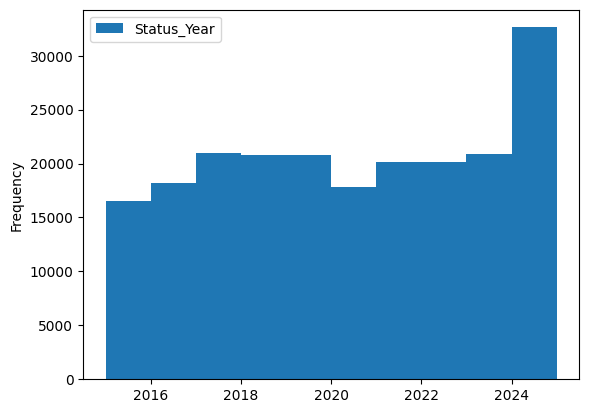

In [64]:
permits_saccity.plot.hist(column=["Status_Year"])

In [69]:
sql_string = """
WITH annotated AS (
    SELECT *,
  
    Type in (
        'Residential'
    ) and Sub_Type in (
        'New Building'
    ) and Category in (
        'Single Family'
    ) and (
        Work_Desc ilike '%shelf-ready%adu%'
        or Work_Desc ilike '%shelf ready%adu%'
        or Work_Desc ilike '%shelf ready plans%'
        or Work_Desc ilike '%shelf made adu%'
        or Project_Name ilike '%shelf-ready%adu%'
        or Project_Name ilike '%shelf ready%adu%'
        or Project_Name ilike '%shelf ready plans%'
        or Project_Name ilike '%shelf made adu%'
    ) as certainly_shelf_ready_adu,
    
  FROM permits_saccity
)

SELECT Status_Year, count(*) as saccity_shelf_ready_adu_permits_issued
FROM annotated
WHERE certainly_shelf_ready_adu
group by Status_Year 
having saccity_shelf_ready_adu_permits_issued > 1
order by Status_Year 
"""

saccity_shelf_ready_adu_permits_issued_by_year = duckdb.query(sql_string).df()

<Axes: xlabel='Status_Year'>

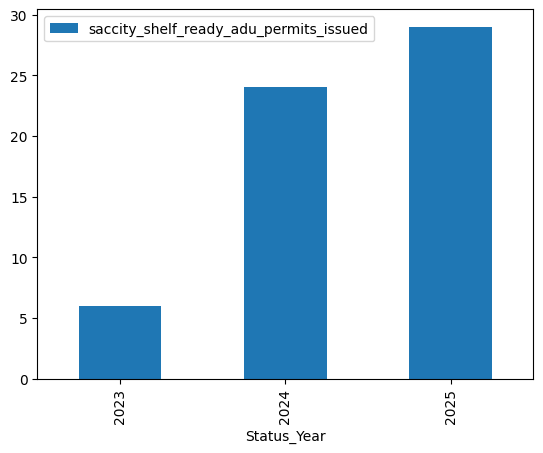

In [71]:
saccity_shelf_ready_adu_permits_issued_by_year.plot(x='Status_Year', y=['saccity_shelf_ready_adu_permits_issued'], kind='bar')

In [67]:
sql_string = """
WITH annotated AS (
  SELECT *,
  
    Type in (
      'Residential'
    )
    and Sub_Type in (
         'New Building'
    ) and Category in (
         'Single Family'
    ) and (
        Work_Desc ilike '%shelf-ready%adu%'
        or Work_Desc ilike '%shelf ready%adu%'
        or Work_Desc ilike '%shelf ready plans%'
        or Work_Desc ilike '%shelf made adu%'
        or Project_Name ilike '%shelf-ready%adu%'
        or Project_Name ilike '%shelf ready%adu%'
        or Project_Name ilike '%shelf ready plans%'
        or Project_Name ilike '%shelf made adu%'
    ) as certainly_shelf_ready_adu,

    Type in (
      'Residential'
    )
    and Sub_Type in (
         'New Building'
    ) and Category in (
         'Single Family'
    ) and (
        Work_Desc ilike '%adu%'
        or Project_Name ilike '%adu%'
    ) as probably_adu,
    
  FROM permits_saccity
)

SELECT *
FROM annotated
WHERE not certainly_shelf_ready_adu and probably_adu
order by Status_Date desc
"""

probably_adu = duckdb.query(sql_string).df()
for x in probably_adu['Work_Desc']:
    print(x)

EPC - EXPEDITED - New 1 bed 1 bath 361 square foot Detached ADU on upper level with 275 square foot garage on lower level.Carbon monoxide & Smoke alarms required. Reference CRC sections R315 & R314. Water conserving fixtures are required to be installed throughout this residence per SB 407 (Note: Residences built after January 1, 1994 are exempt).
“Any new landscaping done on this property is to be in compliance with the City’s Water Efficient Landscape Ordinance 15.92.”

Demo of 324 square feet, 1 story detached garage on issued permit RES-2500206.
EPC - New 555 s.f. Detached ADU with 1 Bedroom and 1 Bathroom. + 54 S/F Porch/Roof Covering, + 14 S/F Utility Closet with exterior door. Total project 623 S/F. This is a Primary record of Shared Plans. PV Exempt. 
Carbon monoxide & Smoke alarms required. Reference CRC sections R315 & R314. Water conserving fixtures are required to be installed throughout this residence per SB 407 (Note: Residences built after January 1, 1994 are exempt).
“A